### **1. 모듈 준비**

In [1]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.4 MB/s eta 0:00:00


In [2]:
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob, pickle
import os
import warnings
warnings.filterwarnings("ignore")
# 경고메세지 생략, 오류메세지만 나오도록함.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Attention, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
import tensorflow_addons as tfa
import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten, BatchNormalization, Input, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import  multilabel_confusion_matrix, multilabel_confusion_matrix, log_loss
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve
from sklearn.preprocessing import Binarizer, minmax_scale

### **2. 분석준비**

In [3]:
base_dir = "/content/drive/MyDrive/audio_project"
# 기본 direction 이동. 원래는 /content
os.chdir(base_dir)

# zipfile access
zip_access = zipfile.ZipFile('audio_data_all.zip','r')

# name_list 첫 번쨰 원소: '감정 분류 Mels, Mffc, Voice quality data/test_labels.pkl'
name_list = zip_access.namelist()

# 확장자별 파일 이름 분류
pkl_file = []
csv_file = []

for file_name in name_list:
    # 확장자 파일명확인
    ext_name = file_name.split('.')[-1]
    if ext_name == 'pkl':
        pkl_file.append(file_name)
    elif ext_name == 'csv':
        csv_file.append(file_name)

for pkl in pkl_file:
    with zip_access.open(pkl) as pickle_file:
        # 확장자 명을 제외한 부분을 변수명으로. ex) test_labels
        name = pkl.split('/')[-1].strip(".pkl")
        globals()["{}".format(name)] = pickle.load(pickle_file)

In [4]:
def lstm_data_trans(arr):
    arr = np.array([i.transpose() for i in arr])
    return arr

def img_data_trans(arr):
    arr = np.expand_dims(arr,-1)
    return arr

def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

### **3. 모델 정의**

In [34]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size[0], self.patch_size[1], 1],
            strides=[1, self.patch_size[0], self.patch_size[1], 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]

        patches = tf.reshape(patches, [batch_size, -1, patch_dims])

        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier(input_shape_vit, transformer_layers, num_heads, projection_dim, num_patches, transformer_units):
    inputs = layers.Input(shape=input_shape_vit)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=(projection_dim//num_heads), dropout=0.1)(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.4)(representation)

    # activation = 'relu' 추가하고 학습 잘됨.
    representation = layers.Dense(20, activation='relu')(representation)
    # skip connection 없으면 성능 낮아지더라.
    representation = layers.Dense(20)(representation) + representation
    representation = layers.ReLU()(representation)

    return models.Model(inputs=inputs, outputs=representation)

def create_bilstm_classifier(input_dim_bilstm):

    model = Sequential()
    model.add(Bidirectional(LSTM(150, dropout = 0.2,return_sequences=True), merge_mode='ave', input_shape=input_dim_bilstm))
    model.add(Bidirectional(LSTM(100, dropout = 0.2,return_sequences=True), merge_mode='ave'))
    model.add(Bidirectional(LSTM(40, dropout = 0.2, return_sequences = True), merge_mode='ave'))
    model.add(Bidirectional(LSTM(20)))
    # average로 merge하지 않고 dense layer에 통과시킨다.
    model.add(Dense(20, activation = 'relu'))

    return model

from tensorflow.keras.regularizers import l2

# Fusion 모델 생성 함수
def create_fusion_model(input_shape_vit, input_dim_bilstm, transformer_layers, num_heads, projection_dim, num_patches, transformer_units):

    # Vision-Transformer 모델 생성
    input_vit = layers.Input(shape=input_shape_vit)
    vit_output = create_vit_classifier(input_shape_vit, transformer_layers, num_heads, projection_dim, num_patches, transformer_units)(input_vit)

    # CNN 모델 생성
    input_bilstm = layers.Input(shape=input_dim_bilstm)
    bilstm_output = create_bilstm_classifier(input_dim_bilstm)(input_bilstm)


    # 두 모델의 출력을 Concatenate
    concatenated = layers.Concatenate()([vit_output, bilstm_output])

    #Fusion 모델의 추가 레이어
    x = layers.Dense(30, activation='relu', kernel_regularizer = l2(0.0001))(concatenated)
    x = layers.Dropout(0.45)(x)
    # skip connection 추가
    x = layers.Dense(30)(x) + x
    x = layers.ReLU()(x)
    output = layers.Dense(5, activation='sigmoid')(x)  # 최종 출력 레이어

    # Fusion 모델 생성
    fusion_model = models.Model(inputs=[input_vit, input_bilstm], outputs=output)
    return fusion_model

### **4.시각화 함수 정의**

In [6]:
def plot_history(history):

    plt.figure(figsize=(10 ,5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epcohs', weight = 'bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs', weight = 'bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 그래프 보이기
    plt.show()

def calculate_metrics(y_test, y_pred):
    label = ['happiness','sadness','angry','neutral','disgust']
    num_classes = 5
    accuracy = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    # sigmoid threshold에 맞게 값 변환

    # 저장되어 있는 주소 때문에 새로운 주소에 copy해야 원래 리스트가 변하지 않는다.
    cal_pred = y_pred.copy()
    cal_test = y_test.copy()

    for a in range(len(cal_pred)):
        for b in range(num_classes):
            if cal_pred[a][b] >= threshold_list[b]:
                cal_pred[a][b] = 1
            else:
                cal_pred[a][b] = 0

    for i in range(num_classes):
        true_positives = np.sum((cal_test[:, i] == 1) & (cal_pred[:, i] == 1))
        false_positives = np.sum((cal_test[:, i] == 0) & (cal_pred[:, i] == 1))
        false_negatives = np.sum((cal_test[:, i] == 1) & (cal_pred[:, i] == 0))
        true_negatives = np.sum((cal_test[:, i] == 0) & (cal_pred[:, i] == 0))
        accuracy[i] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-10)
        precision[i] = true_positives / (true_positives + false_positives + 1e-10)
        recall[i] = true_positives / (true_positives + false_negatives + 1e-10)
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10)

        print(f"{label[i]} --- Accuracy: {accuracy[i]:.4f}, Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1_score[i]:.4f} \n")
    return cal_pred

### **5. 모델 학습**

In [7]:
# X_train_lstm, y_train = lstm_data_trans(train_mfcc_data)[idx_1], np.array(train_labels_sets)[idx_1]
X_train_lstm, y_train = lstm_data_trans(train_mfcc_data), np.array(train_labels_sets)
X_test_lstm, y_test = lstm_data_trans(test_mfcc_data), np.array(test_labels_sets)
X_val_lstm, y_val = lstm_data_trans(val_mfcc_data), np.array(val_labels_sets)

#X_train_vit = img_data_trans(train_mels_data)[idx_1]
X_train_vit = img_data_trans(train_mels_data)
X_test_vit = img_data_trans(test_mels_data)
X_val_vit = img_data_trans(val_mels_data)

print(f'X_train_lstm shape: {X_train_lstm.shape}, X_train_vit shape: {X_train_vit.shape},y_train.shape: {y_train.shape}')
print(f'X_test_lstm shape: {X_test_lstm.shape}, X_test_vit shape: {X_test_vit.shape}, y_test.shape: {y_test.shape}')
print(f'X_val_lstm shape: {X_val_lstm.shape}, X_val_vit shape: {X_val_vit.shape}, y_val.shape: {y_val.shape}')

X_train_lstm shape: (71340, 300, 40), X_train_vit shape: (71340, 100, 300, 1),y_train.shape: (71340, 5)
X_test_lstm shape: (12849, 300, 40), X_test_vit shape: (12849, 100, 300, 1), y_test.shape: (12849, 5)
X_val_lstm shape: (11968, 300, 40), X_val_vit shape: (11968, 100, 300, 1), y_val.shape: (11968, 5)


In [8]:
num_classes = 5
input_shape_vit = (100,300,1)
input_shape_bilstm = (300, 40)

width_len = 5
height_len = 100
patch_size = (height_len, width_len)
num_patches = (input_shape_vit[1]//patch_size[1])

projection_dim = 64

transformer_units = [
    projection_dim * 2,
    projection_dim]

transformer_layers = 6

mlp_head_units = [1024,512]
num_heads = 8

In [30]:
fusion_model = create_fusion_model(input_shape_vit, input_shape_bilstm, transformer_layers, num_heads, projection_dim, num_patches, transformer_units)
fusion_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 100, 300, 1)]        0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 300, 40)]            0         []                            
                                                                                                  
 model_6 (Functional)        (None, 20)                   313684    ['input_10[0][0]']            
                                                                                                  
 sequential_3 (Sequential)   (None, 20)                   485700    ['input_12[0][0]']            
                                                                                            

In [25]:
learning_rate = 0.0006
num_epochs = 50
epochs = 100
batch_size = 256
patience = 6
threshold_values = 0.5
weight_decay = 0.0001

* patience를 낮게 잡아 early stop된 이후 모델을 재정의하지 않고 바로 돌림.
* 현재 epoch 44에서 멈추었으나 64에서 멈춘것과 같음.

In [36]:
def run_experiment(model):
    # weight_decay: L2 정규화
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(optimizer=optimizer, loss ='binary_crossentropy', metrics= [tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
    # val데이터셋의 손실함수값을 최소화하는 것을 모니터링 하겠다. 멈추면 출력하겠다.(verbose) 성능이 향상되지 않아도 6걸음 나아가겠다.
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, verbose =1, mode = 'min' )
    mc = ModelCheckpoint('best_model.hdf5', monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')

    history = fusion_model.fit([X_train_vit,X_train_lstm], y_train,
                               epochs=epochs,
                               batch_size=batch_size,
                               validation_data=([X_val_vit, X_val_lstm], y_val),
                               callbacks=[earlystopping, mc])
    return history, model

history,model = run_experiment(fusion_model)

Epoch 1/100
279/279 [==============================] - ETA: 0s - loss: 0.5858 - binary_accuracy: 0.6912
Epoch 1: val_binary_accuracy improved from -inf to 0.68387, saving model to best_model.hdf5
279/279 [==============================] - 62s 156ms/step - loss: 0.5858 - binary_accuracy: 0.6912 - val_loss: 0.5927 - val_binary_accuracy: 0.6839
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 0.5854 - binary_accuracy: 0.6916
Epoch 2: val_binary_accuracy did not improve from 0.68387
279/279 [==============================] - 37s 131ms/step - loss: 0.5854 - binary_accuracy: 0.6916 - val_loss: 0.5961 - val_binary_accuracy: 0.6830
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.5804 - binary_accuracy: 0.6948
Epoch 3: val_binary_accuracy improved from 0.68387 to 0.68606, saving model to best_model.hdf5
279/279 [==============================] - 38s 136ms/step - loss: 0.5804 - binary_accuracy: 0.6948 - val_loss: 0.5894 - val_binary_accuracy: 0.6861

### **6. 결과 확인**

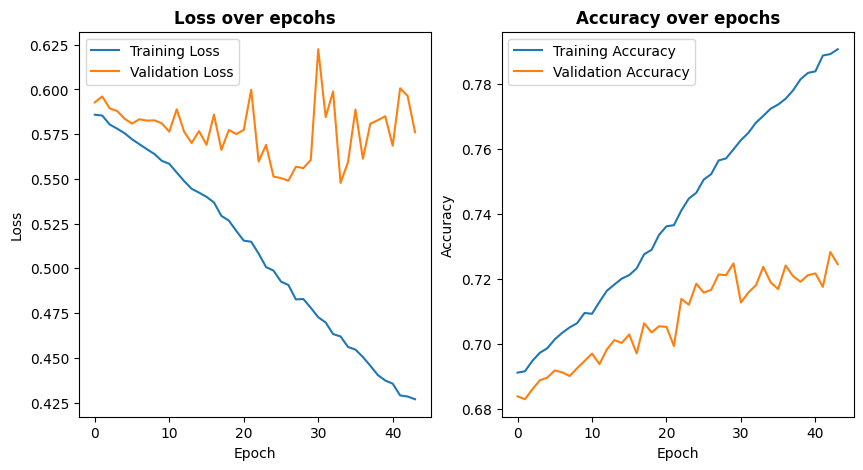

In [38]:
plot_history(history)

In [39]:
y_pred = fusion_model.predict([X_test_vit, X_test_lstm])

print("\nthreshold값 0.4 통일")
threshold_list = [0.4,0.4,0.4,0.4,0.4]
cal_pred1 = calculate_metrics(y_test, y_pred) # calculated 된 pred
accuracy = accuracy_score(y_test, cal_pred1)
print(f"accuarcy 값: {accuracy}")

print("\nthreshold값 0.5 통일")
threshold_list = [0.5,0.5,0.5,0.5,0.5]
cal_pred2 = calculate_metrics(y_test, y_pred)
accuracy = accuracy_score(y_test, cal_pred2)
print(f"accuarcy 값: {accuracy}")

402/402 [==============================] - 18s 37ms/step

threshold값 0.4 통일
happiness --- Accuracy: 0.8177, Precision: 0.7474, Recall: 0.4911, F1: 0.5927 

sadness --- Accuracy: 0.6577, Precision: 0.5605, Recall: 0.6222, F1: 0.5897 

angry --- Accuracy: 0.6332, Precision: 0.4295, Recall: 0.5680, F1: 0.4891 

neutral --- Accuracy: 0.6459, Precision: 0.5168, Recall: 0.6290, F1: 0.5674 

disgust --- Accuracy: 0.7766, Precision: 0.5906, Recall: 0.5384, F1: 0.5633 

accuarcy 값: 0.23962954315510934

threshold값 0.5 통일
happiness --- Accuracy: 0.8150, Precision: 0.7848, Recall: 0.4340, F1: 0.5589 

sadness --- Accuracy: 0.6784, Precision: 0.6389, Recall: 0.4291, F1: 0.5134 

angry --- Accuracy: 0.6888, Precision: 0.4915, Recall: 0.1888, F1: 0.2728 

neutral --- Accuracy: 0.6801, Precision: 0.5858, Recall: 0.4562, F1: 0.5129 

disgust --- Accuracy: 0.7861, Precision: 0.6376, Recall: 0.4651, F1: 0.5378 

accuarcy 값: 0.22219627986613744


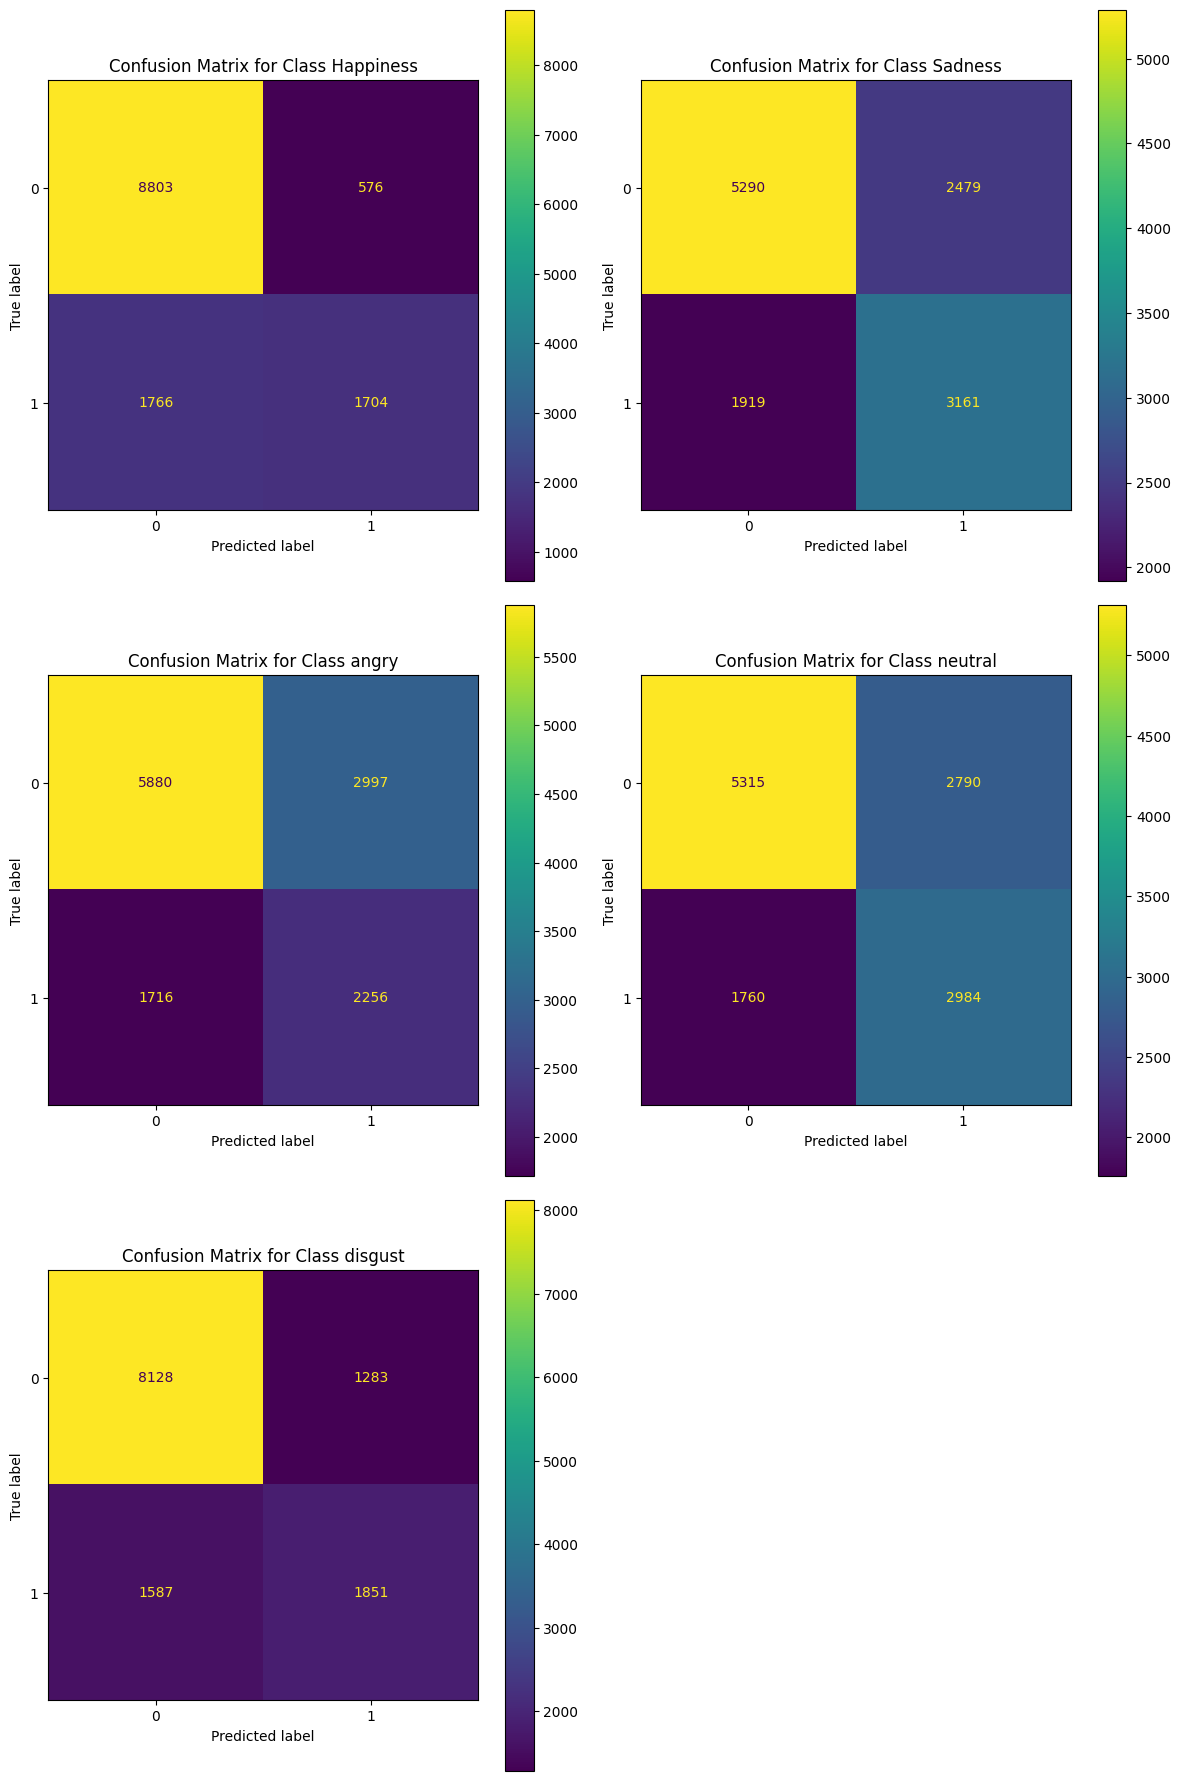

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label_num = {0: "Happiness", 1: "Sadness", 2: "angry", 3: "neutral", 4: "disgust"}

# 일단 통일성을 위해 thres 0.4인 경우 실행결과 값의 confusion matrix를 확인
custom_y_test = cal_pred1.copy()
num_classes = 5

fig, axes = plt.subplots(3, 2, figsize = (12,18))

for class_idx in range(num_classes):
    class_true = y_test[:, class_idx]
    class_pred = custom_y_test[:, class_idx]

    # 혼동 행렬 계산
    cm = confusion_matrix(class_true, class_pred)

    # subplot 인덱스 계산(열로 나누면 )
    row_idx = class_idx // 2
    col_idx = class_idx % 2

    # 혼동 행렬 플롯
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)

    # 플롯 설정

    axes[row_idx, col_idx].set_title(f'Confusion Matrix for Class {label_num[class_idx]}')
    axes[row_idx, col_idx].set_xlabel('Predicted Label')
    axes[row_idx, col_idx].set_ylabel('True Label')
    disp.plot(ax = axes[row_idx, col_idx])
    axes[row_idx, col_idx].grid(False)

axes[2, 1].axis('off') # 나머지인 3행 2열 axes는 정보가 없으므로 끈다. (2,1)인 이유는 시작 idx가 0이기에 그렇다.
plt.tight_layout()
plt.show()

In [41]:
accuracy = accuracy_score(y_test, cal_pred1)
print(f"0.4일때 accuarcy 값: {accuracy}") # 정확히 맞춘경우

def trans_to_series(pred_list):
    return pd.Series(["".join(list(map(str,map(int, i)))) for i in pred_list]).value_counts()

cal_pred1 = pd.DataFrame(trans_to_series(cal_pred1)).reset_index()
cal_pred2 = pd.DataFrame(trans_to_series(cal_pred2)).reset_index()
answer = pd.DataFrame(trans_to_series(y_test)).reset_index()


agg_df = pd.merge(cal_pred1, cal_pred2, right_on = "index", left_on = "index", how = "outer")
agg_df = pd.merge(agg_df, answer, right_on = "index", left_on = "index", how = "outer")
agg_df.columns = ["index", "pred_0.4","pred_0.5","answer"]
agg_df.fillna(0, inplace = True)
agg_df.iloc[:,1:] = agg_df.iloc[:,1:].astype("int")
print(agg_df)

0.4일때 accuarcy 값: 0.23962954315510934
    index  pred_0.4  pred_0.5  answer
0   01000      2239      2188    1013
1   00110      1634        52     799
2   00010      1586      2611    1069
3   10010      1337       590    1114
4   00101      1156       158    1085
5   01100      1020         0     982
6   11000       776       544    1317
7   01001       745       680     796
8   00011       497       441     790
9   00100       475      1316    1106
10  01101       380         0       0
11  01110       348         0       0
12  00111       240         0       0
13  10000       162       785    1039
14  01010       127         0     972
15  00001       116      1229     767
16  00000         6      2255       0
17  11010         5         0       0


* 참고

In [7]:
# 나눠서 학습하는 경우 지금은 A100이 잘 연결되나 안될 떄 참조
# total_rows = 71340

# # 5000개의 인덱스를 랜덤하게 선택하여 idx_1에 저장
# idx_1 = np.random.choice(total_rows, size=35000, replace=False)

# # idx_1을 제외한 나머지 인덱스를 idx_2로 저장
# idx_2 = np.setdiff1d(np.arange(total_rows), idx_1)